In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding using feature-engine
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder

In [2]:
data = pd.read_csv('creditApprovalUCI.csv')

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [3]:
# make a list with the categorical variables

vars_categorical = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,  # all data
    data['A16'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((483, 16), (207, 16))

## Weight of Evidence with pandas

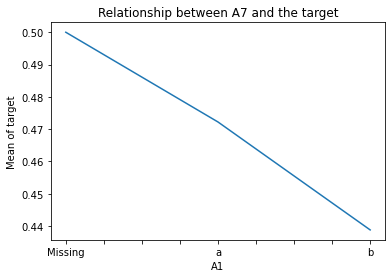

In [5]:
X_train.groupby(['A1'])['A16'].mean().plot()
plt.title('Relationship between A7 and the target')
plt.ylabel('Mean of target')
plt.show()

In [6]:
# Add inverse of the target to train set
X_train['A16_inv'] = 1 - X_train['A16']

<ipython-input-6-24a2eeb34fc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['A16_inv'] = 1 - X_train['A16']


In [7]:
# total numner of observations with target == 1
total_p1 = X_train['A16'].sum()

# total numner of observations with target == 0
total_p0 = X_train['A16_inv'].sum()

p1 = X_train.groupby(['A1'])['A16'].mean() / total_p1
p0 = X_train.groupby(['A1'])['A16_inv'].mean() / total_p0

woe = dict(np.log(p1 / p0))

In [8]:
woe

{'Missing': 0.20359895524123955,
 'a': 0.09237332013101507,
 'b': -0.04241042080997362}

In [9]:
# replace the labels with the woe

X_train['A1'] = X_train['A1'].map(woe)
X_test['A1'] = X_test['A1'].map(woe)

<ipython-input-9-6bfdd0caae9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['A1'] = X_train['A1'].map(woe)
<ipython-input-9-6bfdd0caae9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['A1'] = X_test['A1'].map(woe)


In [10]:
X_train['A1'].head()

596    0.092373
303    0.092373
204   -0.042410
351   -0.042410
118   -0.042410
Name: A1, dtype: float64

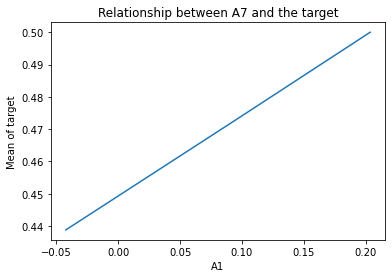

In [11]:
X_train.groupby(['A1'])['A16'].mean().plot()
plt.title('Relationship between A7 and the target')
plt.ylabel('Mean of target')
plt.show()

## Weight of Evidence with Feature-Engine

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['A16'], axis=1),  # predictors
    data['A16'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

In [13]:
# create the weight of evidence encoder

woe_enc = WoERatioCategoricalEncoder(
    encoding_method='woe',
    variables=['A1', 'A10', 'A12'])

In [14]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

woe_enc.fit(X_train, y_train)

WoERatioCategoricalEncoder(encoding_method='woe',
                           variables=['A1', 'A10', 'A12'])

In [15]:
# let's inspect the variables that will be encoded

woe_enc.variables

['A1', 'A10', 'A12']

In [16]:
# the encoder stores the woe values per category per variable

woe_enc.encoder_dict_

{'A1': {'Missing': 0.20359895524123955,
  'a': 0.09237332013101507,
  'b': -0.04241042080997339},
 'A10': {'f': -0.8900993186244411, 't': 1.064410534795166},
 'A12': {'f': 0.012909148776768313, 't': -0.015454610821445114}}

In [17]:
# let's transform train and test sets

X_train_enc = woe_enc.transform(X_train)
X_test_enc = woe_enc.transform(X_test)

In [18]:
X_train_enc.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
596,0.092373,46.08,3.000,u,g,c,v,2.375,t,1.064411,8,-0.015455,g,396.0,4159
303,0.092373,15.92,2.875,u,g,q,v,0.085,f,-0.890099,0,0.012909,g,120.0,0
204,-0.042410,36.33,2.125,y,p,w,v,0.085,t,1.064411,1,0.012909,g,50.0,1187
351,-0.042410,22.17,0.585,y,p,ff,ff,0.000,f,-0.890099,0,0.012909,g,100.0,0
118,-0.042410,57.83,7.040,u,g,m,v,14.000,t,1.064411,6,-0.015455,g,360.0,1332


In [19]:
X_test_enc.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
14,0.092373,45.83,10.50,u,g,q,v,5.000,t,1.064411,7,-0.015455,g,0.0,0
586,-0.042410,64.08,20.00,u,g,x,h,17.500,t,1.064411,9,-0.015455,g,0.0,1000
140,0.092373,31.25,3.75,u,g,cc,h,0.625,t,1.064411,9,-0.015455,g,181.0,0
492,-0.042410,39.25,9.50,u,g,m,v,6.500,t,1.064411,14,0.012909,g,240.0,4607
350,0.092373,26.17,2.00,u,g,j,j,0.000,f,-0.890099,0,-0.015455,g,276.0,1
